## Load files

Updated May 19

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# !pip uninstall scikit-learn
!pip install scikit-learn==1.0.2
!pip install scikit-survival==0.17.2
!pip install lifelines umap-learn > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 41.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is l

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import tifffile as tf
from scipy.stats import ttest_ind
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter
import re
import numpy as np
import warnings

# Set the seed
np.random.seed(99)

In [ ]:
import numpy as np

num_channels = 37
folder = 'cells_subsample'

# Load the data from the appropriate folder
image_mean = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/image_mean.npy', allow_pickle=True)
tile_location = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/tile_location.npy', allow_pickle=True)
sample_name = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/sample_name.npy', allow_pickle=True)
embedding_mean = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/embedding_mean.npy', allow_pickle=True)
celltype_array = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/celltypes.npy', allow_pickle=True)
boundaries = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/boundaries.npy', allow_pickle=True)

# Read marker names from the appropriate folder
with open(f'/content/drive/MyDrive/canvas/channels{num_channels}/channels.txt', 'r') as file:
    marker_names = file.read().splitlines()



In [ ]:
# GENERATES KMEANS

import os
import numpy as np
from sklearn.cluster import KMeans

# Define the path where you want to save the KMeans labels
save_path = f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/'

# Define the number of clusters
n_clusters = 40

# Check if the KMeans labels already exist
labels_filename = os.path.join(save_path, f'labels_{n_clusters}.npy')
print(f'looking for {labels_filename}...')
if os.path.exists(labels_filename):
    # Load the existing KMeans labels
    labels = np.load(labels_filename, allow_pickle=True)
    print(f'Using existing KMeans labels: {labels_filename}')
else:
    # Generate new KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding_mean)
    # Save the KMeans labels
    np.save(labels_filename, kmeans.labels_)
    print(f'New KMeans labels generated and saved: {labels_filename}')
    labels = kmeans.labels_

looking for /content/drive/MyDrive/canvas/channels37/cells_subsample/labels_40.npy...
Using existing KMeans labels: /content/drive/MyDrive/canvas/channels37/cells_subsample/labels_40.npy


In [ ]:
import json

# Process tile_location to convert tensor to plain array and swap coordinates
tile_location_processed = [list(map(int, loc.tolist()))[::-1] for loc in tile_location]

boundaries_processed = [list(map(lambda x: x[::-1], json.loads(b))) for b in boundaries]

# Create DataFrame
master_df = pd.DataFrame({
    'sample_name': sample_name,
    'celltype': celltype_array,
    'labels': labels,
    'tile_location': tile_location_processed,
    'boundaries': boundaries_processed
})

master_df['patient_name'] = np.array([re.match(r"(Glioma|BrM)_[0-9]+", name).group() if re.match(r"(Glioma|BrM)_[0-9]+", name) else None for name in master_df['sample_name']])

In [ ]:
# CREATES THE DATA FRAME AND DETERMINES MARKER COLORS
# Define marker names for different channel counts
markers_20 = ['CD11c', 'CD14', 'CD163', 'CD16', 'CD31', 'CD3', 'CD4', 'CD68', 'CD8', 'DNA1', 'GFAP', 'HLA-DR', 'MPO', 'Olig2', 'P2PY12', 'Sox2', 'Sox9', 'MeLanA', 'PMEL', 'PanCK']
markers_37 = ['CD117', 'CD11c', 'CD14', 'CD163', 'CD16', 'CD20', 'CD31', 'CD3', 'CD4', 'CD68', 'CD8', 'CD94', 'DNA1', 'FoxP3', 'GFAP', 'HLA-DR', 'MPO', 'Olig2', 'P2PY12', 'Sox2', 'Sox9', 'Ki67', 'HIF1a', 'CD45', 'CD206', 'MMP9', 'pSTAT3', 'Ox40L', 'CD39', 'CD40', 'c-Caspase3', 'Claudin5', 'MeLanA', 'PMEL', 'PanCK', 'CIRP', 'pERK']
markers_38 = ['CD117', 'CD11c', 'CD14', 'CD163', 'CD16', 'CD20', 'CD31', 'CD3', 'CD4', 'CD68', 'CD8', 'CD94', 'DNA1', 'FoxP3', 'GFAP', 'HLA-DR', 'MPO', 'Olig2', 'P2PY12', 'Sox2', 'Sox9', 'Ki67', 'HIF1a', 'CD45', 'CD206', 'MMP9', 'pSTAT3', 'Ox40L', 'CD94x', 'CD39', 'CD40', 'c-Caspase3', 'Claudin5', 'MeLanA', 'PMEL', 'PanCK', 'CIRP', 'pERK']

# Combine tab20 and tab20b colors
tab20_colors = plt.get_cmap('tab20').colors
tab20b_colors = plt.get_cmap('tab20b').colors
combined_colors = tab20_colors + tab20b_colors

# Assign colors to markers
marker_colors_20 = dict(zip(markers_20, combined_colors[:len(markers_20)]))
marker_colors_37 = dict(zip(markers_37, combined_colors[:len(markers_37)]))
marker_colors_38 = dict(zip(markers_38, combined_colors[:len(markers_38)]))

# Determine the markers and colormap to use based on the number of channels
num_channels = image_mean.shape[1]
if num_channels == 20:
    marker_names = markers_20
    marker_colors = marker_colors_20
elif num_channels == 37:
    marker_names = markers_37
    marker_colors = marker_colors_37

elif num_channels == 38:
    marker_names = markers_38
    marker_colors = marker_colors_38
else:
    raise ValueError(f"Unexpected number of channels: {num_channels}")

# Add image_mean data as separate columns for each marker
for i, marker in enumerate(marker_names):
    master_df[marker] = image_mean[:, i]

celltype_colors = {
    'Alt BMDM': '#1f77b4',
    'Alt MG': '#aec7e8',
    'Astrocytes': '#ff7f0e',
    'B cell': '#ffbb78',
    'Cancer': '#2ca02c',
    'Cl BMDM': '#98df8a',
    'Cl MG': '#d62728',
    'Cl Mo': '#ff9896',
    'DCs cell': '#9467bd',
    'Endothelial cell': '#c5b0d5',
    'Int Mo': '#8c564b',
    'Mast cell': '#c49c94',
    'NK cell': '#e377c2',
    'Neutrophils': '#f7b6d2',
    'Non-Cl Mo': '#7f7f7f',
    'T other': '#c7c7c7',
    'Tc': '#bcbd22',
    'Th': '#dbdb8d',
    'Treg': '#17becf',
    'Unknown': '#9edae5'
}

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans

conditions = ['Astrocytoma', 'Glioblastoma', 'Primary_Bladder', 'Primary_Breast', 'Primary_Colorectal', 'Primary_Gastric', 'Primary_Gastro-intestinal', 'Primary_Lung', 'Primary_Melanoma', 'Primary_Ovarian', 'Glioma Unknown IDH']

patient_df = pd.read_csv('/content/drive/MyDrive/canvas/Clinical Data GBM BrM.csv')

# Process patient_df
patient_df['Event'] = patient_df['OS event (days post surgery)'].apply(lambda x: 1 if 'death' in str(x) else 0)
patient_df['Survival Duration'] = patient_df['OS event (days post surgery)'].str.extract(r'\((\d+)\)').astype(float)
patient_df = patient_df[['Patient ID', 'Age', 'Sex', 'Event', 'Survival Duration', 'Primary Site of Brain Metastasis', 'Tumor Type', 'Local Recurrence (days post surgery)', 'MGMT status']]
patient_df = patient_df.rename(columns={'Patient ID': 'patient_name'})


patient_df['Age'] = pd.to_numeric(patient_df['Age'], errors='coerce')
patient_df['Sex'] = patient_df['Sex'].replace({'F': 1, 'M': 0})

# Adding new condition-based columns
patient_df['Local Recurrence'] = patient_df['Local Recurrence (days post surgery)'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

# Dropping original columns no longer needed for analysis
patient_df = patient_df.drop(columns=['Local Recurrence (days post surgery)'])
patient_df = pd.get_dummies(patient_df, columns=['Primary Site of Brain Metastasis'], prefix='Primary', dtype=int)
patient_df = pd.get_dummies(patient_df, columns=['Tumor Type'], prefix='', prefix_sep='', dtype=int)

patient_df = patient_df.rename(columns={'MGMT status': 'MGMT methylated'})

# Map values: "m" -> 1, "um" -> 0, and keep NaN values as NaN
patient_df['MGMT methylated'] = patient_df['MGMT methylated'].map({'m': 1, 'um': 0}).astype('Int64')

patient_df = patient_df.drop_duplicates(subset='patient_name', keep='first')

In [ ]:
# Load a dataframe of the sample names and labels
labels_df = pd.DataFrame({
    'Sample': sample_name,
    'Cluster': labels
})

# Process labels_df
if 'Sample' in labels_df.columns:
    labels_df['Patient'] = labels_df['Sample'].apply(lambda x: "_".join([x.split('_')[0], x.split('_')[1][:3]]))
    labels_df = labels_df.drop(['Sample'], axis=1)
    labels_df = labels_df.set_index('Patient')

# Create cluster counts (raw counts of cells per cluster for each patient)
cluster_counts = labels_df.groupby(['Patient', 'Cluster']).size().unstack(fill_value=0)

# Align the indices of patient_df with cluster_counts
common_patients = patient_df['patient_name'].isin(cluster_counts.index)

# Step 2: Filter patient_df to include only the common patients
patient_df_aligned = patient_df[common_patients].copy()

patient_df_aligned = patient_df_aligned.set_index('patient_name')

In [ ]:
# Normalize the cluster counts by dividing each value by the row sums to get percentages
row_sums = cluster_counts.sum(axis=1)
cluster_counts_pct = cluster_counts.div(row_sums, axis=0)

# Add the normalized cluster counts to patient_df
patient_df_aligned = patient_df_aligned.join(cluster_counts_pct, how='inner')

# Add raw counts (unnormalized) to patient_df_drop_nan with the column names 'raw_1', 'raw_2', ..., 'raw_n'
raw_cluster_counts = cluster_counts.add_prefix('raw_')
patient_df_aligned = patient_df_aligned.join(raw_cluster_counts, how='inner')

# Add a 'Tumor Origin' column to distinguish between BrM and Glioma
patient_df_aligned['Tumor Origin'] = np.where(patient_df_aligned['Brain Metastasis'] == 1, 'BrM', 'Glioma')

# Drop rows with NaNs in 'Survival Duration' and 'Event'
patient_df_drop_nan = patient_df_aligned.dropna(subset=['Survival Duration', 'Event'])

## Enrichment, dominance, and nearby cells

In [ ]:
# DETERMINE AVG NUMBER OF NEARBY CELLS

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix

# Adjust tile_location to find the center of each cell
def adjust_tile_location(tile_location):
    # Add 8px to each dimension to get the center
    center_x = tile_location[0] + 8
    center_y = tile_location[1] + 8
    return [center_x, center_y]

master_df['center_location'] = master_df['tile_location'].apply(adjust_tile_location)

# Group by sample_name to calculate distances within the same image
results = []

for current_sample_name, group in master_df.groupby('sample_name'):
    # Extract center locations and labels
    centers = np.array(group['center_location'].tolist())
    current_labels = group['labels'].values

    # Calculate the distance matrix
    dist_matrix = distance_matrix(centers, centers)

    # Count the number of cells within 20 pixels (excluding self)
    nearby_counts = (dist_matrix < 20).sum(axis=1) - 1

    # Store the results with labels
    for current_label, count in zip(current_labels, nearby_counts):
        results.append((current_label, count))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['label', 'nearby_count'])

# Calculate the average number of nearby cells, grouped by label
average_nearby_df = results_df.groupby('label')['nearby_count'].mean().reset_index()
average_nearby_df.columns = ['label', 'average_number_of_nearby_cells']

In [ ]:
import pandas as pd

# Assuming master_df is already defined

# Initialize lists to store the counts
glioma_tiles = []
brm_tiles = []
glioma_tiles_normalized = []
brm_tiles_normalized = []
glioma_patients = []
brm_patients = []
dominance = []

# Set the cluster labels from 0 to 49 as the index
cluster_labels = range(n_clusters)

# Calculate the total number of tiles for Glioma and BrM
total_glioma_tiles = master_df[master_df['sample_name'].str.startswith('Glioma')].shape[0]
total_brm_tiles = master_df[master_df['sample_name'].str.startswith('BrM')].shape[0]

# Iterate over each cluster label
for cluster in cluster_labels:
    # Filter the rows for the current cluster
    cluster_df = master_df[master_df['labels'] == cluster]

    # Count the number of tiles for Glioma and BrM in this cluster
    glioma_count = cluster_df[cluster_df['sample_name'].str.startswith('Glioma')].shape[0]
    brm_count = cluster_df[cluster_df['sample_name'].str.startswith('BrM')].shape[0]

    # Normalize the counts to 1,000,000 based on their respective totals, cast to integers
    glioma_normalized = int((glioma_count / total_glioma_tiles) * 1000000) if total_glioma_tiles > 0 else 0
    brm_normalized = int((brm_count / total_brm_tiles) * 1000000) if total_brm_tiles > 0 else 0

    # Group by patient and count the number of patients with at least 10 tiles for Glioma and BrM
    glioma_patient_count = (cluster_df[cluster_df['sample_name'].str.startswith('Glioma')]
                            .groupby('patient_name')
                            .size() >= 10).sum()

    brm_patient_count = (cluster_df[cluster_df['sample_name'].str.startswith('BrM')]
                         .groupby('patient_name')
                         .size() >= 10).sum()

    # Determine dominance using integer comparison
    total_normalized = glioma_normalized + brm_normalized
    if total_normalized == 0:
        dominance.append('Mixed')  # If both counts are 0, mark dominance as 'Mixed'
    elif glioma_normalized >= 0.9 * total_normalized:
        dominance.append('Glioma')
    elif brm_normalized >= 0.9 * total_normalized:
        dominance.append('BrM')
    else:
        dominance.append('Mixed')

    # Append the counts to the lists
    glioma_tiles.append(int(glioma_count))
    brm_tiles.append(int(brm_count))
    glioma_tiles_normalized.append(int(glioma_normalized))
    brm_tiles_normalized.append(int(brm_normalized))
    glioma_patients.append(int(glioma_patient_count))
    brm_patients.append(int(brm_patient_count))

# Create the final DataFrame with cluster labels as index
tile_counts_df = pd.DataFrame({
    'Glioma Tiles': glioma_tiles,
    'BrM Tiles': brm_tiles,
    'Glioma Tiles (Normalized to 1M)': glioma_tiles_normalized,
    'BrM Tiles (Normalized to 1M)': brm_tiles_normalized,
    'Glioma Patients (>=10 Tiles)': glioma_patients,
    'BrM Patients (>=10 Tiles)': brm_patients,
    'Dominance': dominance
}, index=cluster_labels)

# Add a row at the bottom to total the tiles and patients (excluding the Dominance column)
tile_counts_df.loc['Total'] = tile_counts_df.drop(columns=['Dominance']).sum()

# Ensure all values are integers (for safety)
tile_counts_df = tile_counts_df.astype({col: 'int' for col in tile_counts_df.columns if col != 'Dominance'})

# Display the result
tile_counts_df

,Glioma Tiles,BrM Tiles,Glioma Tiles (Normalized to 1M),BrM Tiles (Normalized to 1M),Glioma Patients (>=10 Tiles),BrM Patients (>=10 Tiles),Dominance
0,2216,2308,16216,24475,44,36,Mixed
1,13255,1171,96997,12417,123,37,Mixed
2,3376,502,24704,5323,94,17,Mixed
3,1604,3733,11737,39586,52,46,Mixed
4,379,3391,2773,35959,16,32,BrM
5,12116,6527,88662,69215,106,46,Mixed
6,5594,888,40935,9416,101,34,Mixed
7,533,1097,3900,11633,14,18,Mixed
8,6827,1275,49958,13520,97,37,Mixed
9,8573,0,62735,0,119,0,Glioma


In [ ]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch

# Assuming master_df, marker_names, and celltype_colors are already defined

# Step 1: Create tile_location_df based on master_df
tile_location_df = master_df[['sample_name', 'tile_location', 'labels', 'celltype']].copy()
tile_location_df[['y', 'x']] = pd.DataFrame(tile_location_df['tile_location'].tolist(), index=tile_location_df.index)
tile_location_df.drop(columns=['tile_location'], inplace=True)

# Reorder columns
tile_location_df = tile_location_df[['sample_name', 'x', 'y', 'labels', 'celltype']]

# Step 2: Calculate cell composition by cluster (normalized percentages)
counts = tile_location_df.groupby(['labels', 'celltype']).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Perform hierarchical clustering on modules
dendrogram = sch.dendrogram(sch.linkage(percentages, method='ward'), no_plot=True)
ordered_modules = [percentages.index[i] for i in dendrogram['leaves']]

# Reorder the rows of the DataFrame according to the clustering
percentages = percentages.loc[ordered_modules]

# Step 3: Determine the dominant cell type for each module using a fixed threshold of 40%
dominant_cell_types = percentages.idxmax(axis=1)
dominant_cell_types_percent = percentages.max(axis=1)
dominant_cell_types = dominant_cell_types.where(dominant_cell_types_percent > 40, other='Mixed')

# Step 4: Apply min-max normalization directly on marker columns of master_df
# Normalize marker data
unnormalized_master_df = master_df.copy()

master_df[marker_names] = (master_df[marker_names] - master_df[marker_names].min()) / (master_df[marker_names].max() - master_df[marker_names].min())

# Apply clipping based on the 2nd and 98th percentiles directly on master_df
# master_df[marker_names] = master_df[marker_names].clip(lower=master_df[marker_names].quantile(0.02), upper=master_df[marker_names].quantile(0.98), axis=1)

# Combine the name and marker dataframes
labels_df = master_df[['sample_name', 'labels']].copy()
labels_df.columns = ['Sample', 'Cluster']

# Step 5: Create markers_by_sample_df using normalized and clipped marker data in master_df
markers_by_sample_df = pd.concat([labels_df, master_df[marker_names]], axis=1)

# Group by Cluster and sum the values
markers_by_module_df = markers_by_sample_df.groupby('Cluster').sum()
markers_by_module_df = markers_by_module_df.drop('Sample', axis=1)

# Exclude DNA1 marker from the analysis (if applicable)
if 'DNA1' in markers_by_module_df.columns:
    markers_by_module_df = markers_by_module_df.drop(columns='DNA1')

# Step 6: Normalize for percentage calculation
signature_df = markers_by_module_df.div(markers_by_module_df.sum(axis=1), axis=0) * 100

# Step 7: Determine enriched markers
enriched_markers = (signature_df > 40).astype(int)
top_nth_percentile_markers = (signature_df >= signature_df.quantile(0.90)) & (signature_df > 5)
enriched_markers = enriched_markers | top_nth_percentile_markers

# The modified `master_df` now includes normalized and clipped marker data.

In [ ]:
# Iterate over each cluster in the DataFrame
for cluster in enriched_markers.index:
    # Get the enriched markers for the current cluster (True values)
    enriched = enriched_markers.loc[cluster][enriched_markers.loc[cluster] == True]

    # If there are any enriched markers, print them
    if not enriched.empty:
        enriched_marker_list = enriched.index.tolist()  # List of enriched markers
        print(f"Cluster {cluster}: {', '.join(enriched_marker_list)}")
    else:
        print(f"Cluster {cluster}: No enriched markers")


Cluster 0: CD68, HLA-DR, Ox40L
Cluster 1: GFAP
Cluster 2: CD31, CD39, CD40, Claudin5
Cluster 3: CD163, CD68, Ox40L
Cluster 4: CD3, CD4, CD45
Cluster 5: No enriched markers
Cluster 6: CD31, CD39, CD40, Claudin5
Cluster 7: MPO, MMP9
Cluster 8: CD14, CD163, CD16
Cluster 9: GFAP, Olig2, Sox2, Sox9
Cluster 10: CD117, P2PY12, Ki67, CIRP
Cluster 11: P2PY12
Cluster 12: GFAP
Cluster 13: GFAP, Sox2, Sox9
Cluster 14: Ki67
Cluster 15: Olig2, Sox2, Sox9
Cluster 16: CD68, P2PY12
Cluster 17: CD3, CD8, CD45
Cluster 18: MPO, HIF1a, MMP9
Cluster 19: CD3, CD8, CD45
Cluster 20: CD39
Cluster 21: No enriched markers
Cluster 22: CD20, CD4, CD45
Cluster 23: CD14, CD16, HLA-DR, Ox40L
Cluster 24: CIRP, pERK
Cluster 25: CD14, CD163, CD16, CD4
Cluster 26: CD14, CD163, CD16, CD68
Cluster 27: MeLanA, PMEL
Cluster 28: CD11c, HLA-DR
Cluster 29: MPO, MMP9
Cluster 30: CD117
Cluster 31: P2PY12, CIRP
Cluster 32: CD3, CD4
Cluster 33: Olig2, Sox2, Sox9
Cluster 34: CD31, Claudin5
Cluster 35: CD11c
Cluster 36: CD31, CD39, Cl

## Cox/Kaplan

In [ ]:
brm_patient_df = patient_df_drop_nan[patient_df_drop_nan['Tumor Origin'] == "BrM"].copy()
glioma_patient_df = patient_df_drop_nan[patient_df_drop_nan['Tumor Origin'] == "Glioma"].copy()
all_patient_df = patient_df_drop_nan.copy()

In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to calculate C-index using bootstrapping
def bootstrap_c_index(survival_times, predictions, events, n_bootstraps=1000, ci_level=0.95):
    c_indices = []
    n = len(survival_times)

    for _ in range(n_bootstraps):
        indices = np.random.choice(n, n, replace=True)
        c_index = concordance_index(survival_times[indices], predictions[indices], events[indices])
        c_indices.append(c_index)

    c_index_mean = np.mean(c_indices)
    ci_lower = np.percentile(c_indices, (1 - ci_level) / 2 * 100)
    ci_upper = np.percentile(c_indices, (1 + ci_level) / 2 * 100)

    return c_index_mean, ci_lower, ci_upper

# Function to analyze the C-index for a given DataFrame and determine if it indicates increased or decreased survival
def analyze_c_index(patient_df, type_label, low_percentile=20, high_percentile=80):
    survival_times = patient_df['Survival Duration']
    events = patient_df['Event']

    results = {
        'c-index': [], 'type': [], 'c-index_low': [], 'c-index_high': [],
        'cluster': [], 'c-index_coef': [], 'c-index_direction': []
    }

    for cluster in range(n_clusters):
        cluster_compositions = pd.to_numeric(patient_df[cluster], errors='coerce').dropna()
        if cluster_compositions.empty:
            continue

        # Calculate the C-index
        c_index, ci_lower, ci_upper = bootstrap_c_index(survival_times, cluster_compositions, events.astype(bool))

        # Calculate the correlation between cluster compositions and survival times
        correlation = np.corrcoef(cluster_compositions, survival_times.loc[cluster_compositions.index])[0, 1]

        # Determine the survival direction based on c-index value
        if c_index > 0.6:
            survival_direction = 'up'
        elif c_index < 0.4:
            survival_direction = 'down'
        else:
            survival_direction = 'na'

        results['cluster'].append(cluster)
        results['type'].append(type_label)
        results['c-index'].append(c_index)
        results['c-index_low'].append(ci_lower)
        results['c-index_high'].append(ci_upper)
        results['c-index_coef'].append(correlation)
        results['c-index_direction'].append(survival_direction)

    # Create a DataFrame for C-index results
    c_index_df = pd.DataFrame(results).set_index('cluster')

    return c_index_df

# Analyze each DataFrame separately for C-index
brm_c_index_df = analyze_c_index(brm_patient_df, type_label='BrM')
glioma_c_index_df = analyze_c_index(glioma_patient_df, type_label='Glioma')
all_c_index_df = analyze_c_index(all_patient_df, type_label='All')

# Combine all C-index DataFrames into one
c_index_df = pd.concat([brm_c_index_df, glioma_c_index_df, all_c_index_df]).reset_index()

<ipython-input-23-159a5aee5503>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c_index = concordance_index(survival_times[indices], predictions[indices], events[indices])
<ipython-input-23-159a5aee5503>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c_index = concordance_index(survival_times[indices], predictions[indices], events[indices])
<ipython-input-23-159a5aee5503>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c_inde

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Function to perform univariate Cox analysis, test assumptions, and return a DataFrame with the desired output
def fit_univariate_cox_for_origin(patient_df, origin_label, penalizer=0.01):
    # Subset the DataFrame based on Tumor Origin (BrM, Glioma, or All)
    subset_df = patient_df_drop_nan[patient_df_drop_nan['Tumor Origin'] == origin_label] if origin_label != 'All' else patient_df

    # Initialize results
    results = {'cluster': [], 'type': [], 'uni_cox_coef': [], 'uni_cox_pval': [], 'assumptions_passed': []}

    cph = CoxPHFitter()

    # Loop over each cluster for univariate analysis
    for cluster in cluster_columns:
        if subset_df[cluster].sum() != 0:  # Skip if all values in the cluster column are zero
            # Fit the Cox model using only the current cluster, 'Survival Duration', and 'Event'
            cox_df = subset_df[[cluster, 'Survival Duration', 'Event']].dropna()
            cph.fit(cox_df, duration_col='Survival Duration', event_col='Event')

            # Check proportional hazards assumptions
            try:
                cph.check_assumptions(cox_df, p_value_threshold=0.05, raise_on_violation=False)
                assumptions_passed = True
            except:
                assumptions_passed = False

            # Append the results for the current cluster
            results['cluster'].append(cluster)
            results['type'].append(origin_label)
            results['uni_cox_coef'].append(cph.params_.values[0])
            results['uni_cox_pval'].append(cph.summary['p'].values[0])
            results['assumptions_passed'].append(assumptions_passed)

    # Convert the results to a DataFrame before adding the direction column
    results_df = pd.DataFrame(results)

    # Add the 'uni_cox_direction' column based on the sign of 'uni_cox_coef' and 'uni_cox_pval'
    results_df['uni_cox_direction'] = results_df.apply(
        lambda row: 'up' if row['uni_cox_pval'] <= 0.05 and row['uni_cox_coef'] < 0
        else 'down' if row['uni_cox_pval'] <= 0.05 and row['uni_cox_coef'] > 0
        else 'na', axis=1
    )

    # Return the results DataFrame
    return results_df

# Fit the Cox model separately for BrM, Glioma, and All, and store the results in a combined DataFrame
uni_cox_brm_results = fit_univariate_cox_for_origin(patient_df_drop_nan, 'BrM')
uni_cox_glioma_results = fit_univariate_cox_for_origin(patient_df_drop_nan, 'Glioma')
uni_cox_all_results = fit_univariate_cox_for_origin(patient_df_drop_nan, 'All')

# Combine the results into a single DataFrame
uni_cox_df = pd.concat([uni_cox_brm_results, uni_cox_glioma_results, uni_cox_all_results], ignore_index=True)

# Display the final DataFrame with p-values less than 0.05
uni_cox_df

,cluster,type,uni_cox_coef,uni_cox_pval,assumptions_passed,uni_cox_direction
0,0,BrM,-11.791666,0.311875,False,na
1,1,BrM,-2.737311,0.871263,False,na
2,2,BrM,56.635426,0.002014,False,down
3,3,BrM,7.904684,0.084427,False,na
4,4,BrM,-11.270886,0.218381,False,na
...,...,...,...,...,...,...
111,35,All,1.887092,0.240044,False,na
112,36,All,2.142978,0.664436,False,na
113,37,All,-12.869743,0.337560,False,na
114,38,All,4.267967,0.375496,False,na


In [ ]:
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np

# Function to perform Kaplan-Meier analysis and calculate p-values based on median tile count
def analyze_kaplan_meier_median(patient_df, type_label):
    survival_times = patient_df['Survival Duration']
    events = patient_df['Event']

    results = {
        'cluster': [], 'type': [], 'kaplan_n_low': [], 'kaplan_n_high': [],
        'kaplan_survival_low': [], 'kaplan_survival_high': [],
        'kaplan_pval': []
    }

    for cluster in range(40):  # Assuming you have 40 clusters; adjust based on your data
        cluster_compositions = pd.to_numeric(patient_df[f'raw_{cluster}'], errors='coerce').dropna()
        if cluster_compositions.empty:
            continue

        # Calculate the median tile count
        median_tiles = cluster_compositions.median()

        # Create groups based on the median tile count
        low_group = cluster_compositions <= median_tiles
        high_group = cluster_compositions > median_tiles

        n_high = int(np.sum(high_group))
        n_low = int(np.sum(low_group))

        # Skip clusters where the groups are too small to perform analysis
        if n_low < 1 or n_high < 1:
            continue

        # Calculate average survival times for low and high groups
        avg_survival_low = int(survival_times[low_group].mean())
        avg_survival_high = int(survival_times[high_group].mean())

        # Calculate the Kaplan-Meier p-value using logrank test
        km_test = logrank_test(
            survival_times[low_group],
            survival_times[high_group],
            event_observed_A=events[low_group],
            event_observed_B=events[high_group]
        )
        kaplan_pval = km_test.p_value

        # Append the results for the current cluster
        results['cluster'].append(cluster)
        results['type'].append(type_label)
        results['kaplan_n_low'].append(n_low)
        results['kaplan_n_high'].append(n_high)
        results['kaplan_survival_low'].append(avg_survival_low)
        results['kaplan_survival_high'].append(avg_survival_high)
        results['kaplan_pval'].append(float(kaplan_pval))

    # Create DataFrame and set the index to 'Cluster'
    return pd.DataFrame(results).set_index('cluster')

# Use the existing patient_df_drop_nan DataFrame to filter by Tumor Origin
brm_patient_df = patient_df_drop_nan[patient_df_drop_nan['Tumor Origin'] == "BrM"].copy()
glioma_patient_df = patient_df_drop_nan[patient_df_drop_nan['Tumor Origin'] == "Glioma"].copy()
all_patient_df = patient_df_drop_nan.copy()

# Perform Kaplan-Meier analysis based on median tile count
brm_kaplan_df = analyze_kaplan_meier_median(brm_patient_df, type_label='BrM')
glioma_kaplan_df = analyze_kaplan_meier_median(glioma_patient_df, type_label='Glioma')
all_kaplan_df = analyze_kaplan_meier_median(all_patient_df, type_label='All')

# Combine all Kaplan-Meier DataFrames into one
kaplan_df = pd.concat([brm_kaplan_df, glioma_kaplan_df, all_kaplan_df]).reset_index()

# Convert all relevant columns to integers, excluding 'type' and 'kaplan_pval'
kaplan_df[['kaplan_n_low', 'kaplan_n_high', 'kaplan_survival_low', 'kaplan_survival_high']] = kaplan_df[['kaplan_n_low', 'kaplan_n_high', 'kaplan_survival_low', 'kaplan_survival_high']].astype(int)

# Filter for p-values less than 0.05
kaplan_df[kaplan_df['kaplan_pval'] < 0.06]


,cluster,type,kaplan_n_low,kaplan_n_high,kaplan_survival_low,kaplan_survival_high,kaplan_pval
4,4,BrM,23,23,495,597,0.029019
23,25,BrM,24,22,431,672,0.042984
26,28,BrM,24,22,443,659,0.043364
38,0,Glioma,58,45,745,1073,0.038141
52,14,Glioma,55,48,1052,701,0.007629
55,17,Glioma,56,47,735,1070,0.020412
56,18,Glioma,55,48,726,1074,0.022633
59,21,Glioma,63,40,756,1096,0.049949
60,22,Glioma,72,31,646,1450,0.000039
69,32,Glioma,53,50,709,1078,0.029526


In [ ]:
# Merge c_index_df and uni_cox_df
cindex_cox_kaplan_df_raw = pd.merge(c_index_df, uni_cox_df, on=['cluster', 'type'], how='outer')

# Merge the kaplan_df into the merged DataFrame
cindex_cox_kaplan_df_raw = pd.merge(cindex_cox_kaplan_df_raw, kaplan_df, on=['cluster', 'type'], how='outer')

# Merge multi_cox_df into the final DataFrame
cindex_cox_kaplan_df_raw = pd.merge(cindex_cox_kaplan_df_raw, multi_cox_df, on=['cluster', 'type'], how='outer')

# Merge the Dominance column from tile_counts_df into cindex_cox_kaplan_df_raw
cindex_cox_kaplan_df_raw = pd.merge(cindex_cox_kaplan_df_raw, tile_counts_df[['Dominance']], left_on='cluster', right_index=True, how='left')

# Filter the DataFrame based on the specified conditions
cindex_cox_kaplan_df = cindex_cox_kaplan_df_raw[
    (cindex_cox_kaplan_df_raw['c-index'] > 0.6) |
    (cindex_cox_kaplan_df_raw['c-index'] < 0.4) |
    (cindex_cox_kaplan_df_raw['uni_cox_pval'] < 0.05) |
    (cindex_cox_kaplan_df_raw['multi_cox_pval'] < 0.05) |
    (cindex_cox_kaplan_df_raw['kaplan_pval'] < 0.05)
]

# Reorder columns to make 'type' the second column and include 'Dominance'
columns_order = ['cluster', 'type', 'Dominance'] + [col for col in cindex_cox_kaplan_df.columns if col not in ['cluster', 'type', 'Dominance']]
cindex_cox_kaplan_df = cindex_cox_kaplan_df[columns_order]

# Function to apply color formatting for p-values and C-index separately
def color_values(val, column_name):
    if "pval" in column_name and val < 0.05:
        return 'color: red'
    # Color C-index > 0.6 or < 0.4
    elif "c-index" in column_name and (val > 0.6 or val < 0.4):
        return 'color: red'

# Function to format the numbers and remove unnecessary trailing zeros
def format_values(val):
    if isinstance(val, float):
        if val.is_integer():  # Check if it's a whole number
            return f"{int(val)}"  # Remove decimal point if it's a whole number
        return f"{val:.2f}"  # Keep 2 decimal places for floats
    return val

# Columns order including 'Dominance'
columns_order = [
    'cluster','Dominance', 'type', 'c-index_direction', 'uni_cox_direction', 'multi_cox_direction',
    'c-index', 'c-index_low', 'c-index_high', 'c-index_coef',
    'kaplan_n_low', 'kaplan_n_high', 'kaplan_survival_low', 'kaplan_survival_high', 'kaplan_pval',
    'uni_cox_coef', 'uni_cox_pval', 'multi_cox_coef', 'multi_cox_pval'
]

# Reorder the columns of the DataFrame
cindex_cox_kaplan_df = cindex_cox_kaplan_df[columns_order]

# Format the numeric columns and apply the color formatting
cindex_cox_kaplan_df.style.format(format_values).apply(
    lambda col: col.apply(color_values, column_name=col.name),
    subset=['c-index', 'uni_cox_pval', 'multi_cox_pval', 'kaplan_pval']
)

,cluster,Dominance,type,c-index_direction,uni_cox_direction,multi_cox_direction,c-index,c-index_low,c-index_high,c-index_coef,kaplan_n_low,kaplan_n_high,kaplan_survival_low,kaplan_survival_high,kaplan_pval,uni_cox_coef,uni_cox_pval,multi_cox_coef,multi_cox_pval
0,0,Mixed,All,na,up,na,0.59,0.53,0.64,0.14,75,74,665,902,0.00,-10.40,0.02,-11.03,0.12
2,0,Mixed,Glioma,na,up,na,0.58,0.52,0.65,0.25,58,45,745,1073,0.04,-10.25,0.03,-5.61,0.49
7,2,Mixed,BrM,down,down,na,0.38,0.25,0.52,-0.16,23,23,579,513,0.27,56.64,0.00,89.15,0.18
12,4,BrM,All,na,na,down,0.53,0.47,0.59,-0.10,79,70,811,751,0.30,-8.91,0.21,27.10,0.04
13,4,BrM,BrM,up,na,na,0.63,0.50,0.76,-0.01,23,23,495,597,0.03,-11.27,0.22,32.51,0.15
19,6,Mixed,BrM,down,na,na,0.39,0.25,0.54,-0.08,23,23,581,511,0.42,25.76,0.32,-50.29,0.54
32,10,BrM,Glioma,na,up,up,0.56,0.51,0.61,0.25,73,30,776,1161,0.07,-177.11,0.05,-434.80,0.00
42,14,Mixed,All,na,down,na,0.43,0.38,0.49,-0.27,76,73,946,613,0.28,28.38,0.01,23.57,0.22
44,14,Mixed,Glioma,na,down,down,0.41,0.35,0.48,-0.24,55,48,1052,701,0.01,45.84,0.01,81.99,0.00
47,15,Glioma,Glioma,na,na,down,0.48,0.41,0.56,-0.09,52,51,826,952,0.49,4.05,0.40,20.19,0.04


## Composition

In [ ]:
import pandas as pd

# Function to extract patient name from sample_name
def extract_patient_name(sample_name):
    if 'BrM' in sample_name:
        return sample_name.split('_')[0] + '_' + sample_name.split('_')[1][:3]
    elif 'Glioma' in sample_name:
        return sample_name.split('_')[0] + '_' + sample_name.split('_')[1][:3]
    else:
        return None

# Add a new column to master_df for the patient name
master_df['patient_name'] = master_df['sample_name'].apply(extract_patient_name)

# List of condition columns in patient_df
condition_columns = ['Primary_Bladder', 'Primary_Breast', 'Primary_Colorectal',
                     'Primary_Gastric', 'Primary_Gastro-intestinal', 'Primary_Lung',
                     'Primary_Melanoma', 'Primary_Ovarian', 'Astrocytoma',
                     'Glioblastoma', 'Glioma Unknown IDH']

# Function to get condition type based on patient name
def get_condition_type(patient_name):
    if patient_name in patient_df.index:  # Ensure patient_name exists in patient_df
        patient_row = patient_df.loc[patient_name]
        for condition in condition_columns:
            if patient_row[condition] == 1:
                return condition
    return None

# Add the 'condition type' column to master_df
master_df['condition type'] = master_df['patient_name'].apply(get_condition_type)

# Drop the helper 'patient_name' column as it's no longer needed
master_df = master_df.drop(columns=['patient_name'])

# Display the updated master_df
master_df.head()

,sample_name,celltype,labels,tile_location,boundaries,CD117,CD11c,CD14,CD163,CD16,...,CD40,c-Caspase3,Claudin5,MeLanA,PMEL,PanCK,CIRP,pERK,center_location,condition type
0,BrM_044C2,Alt BMDM,23,"[290, 505]","[[296, 511], [296, 512], [296, 513], [296, 514...",0.0,0.122986,0.256104,0.335938,0.343262,...,0.0,0.002932,0.0,0.0,0.0,0.021744,0.037262,0.015236,"[298, 513]",None
1,BrM_044C2,Alt BMDM,3,"[166, 69]","[[172, 75], [172, 76], [172, 77], [172, 78], [...",0.0,0.000000,0.083374,0.311279,0.042084,...,0.0,0.053558,0.0,0.0,0.0,0.023956,0.002502,0.004486,"[174, 77]",None
2,BrM_044C2,Alt BMDM,26,"[84, 429]","[[88, 436], [88, 437], [88, 438], [89, 440], [...",0.0,0.000000,0.000000,0.212036,0.000000,...,0.0,0.021759,0.0,0.0,0.0,0.000000,0.000000,0.000000,"[92, 437]",None
3,BrM_044C2,Alt BMDM,26,"[211, 28]","[[214, 34], [214, 35], [214, 36], [214, 37], [...",0.0,0.000000,0.000000,0.206177,0.118896,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.002239,"[219, 36]",None
4,BrM_044C2,Alt BMDM,29,"[250, 724]","[[255, 730], [255, 731], [255, 732], [256, 734...",0.0,0.112732,0.082458,0.203857,0.024475,...,0.0,0.055206,0.0,0.0,0.0,0.000000,0.017502,0.029160,"[258, 732]",None


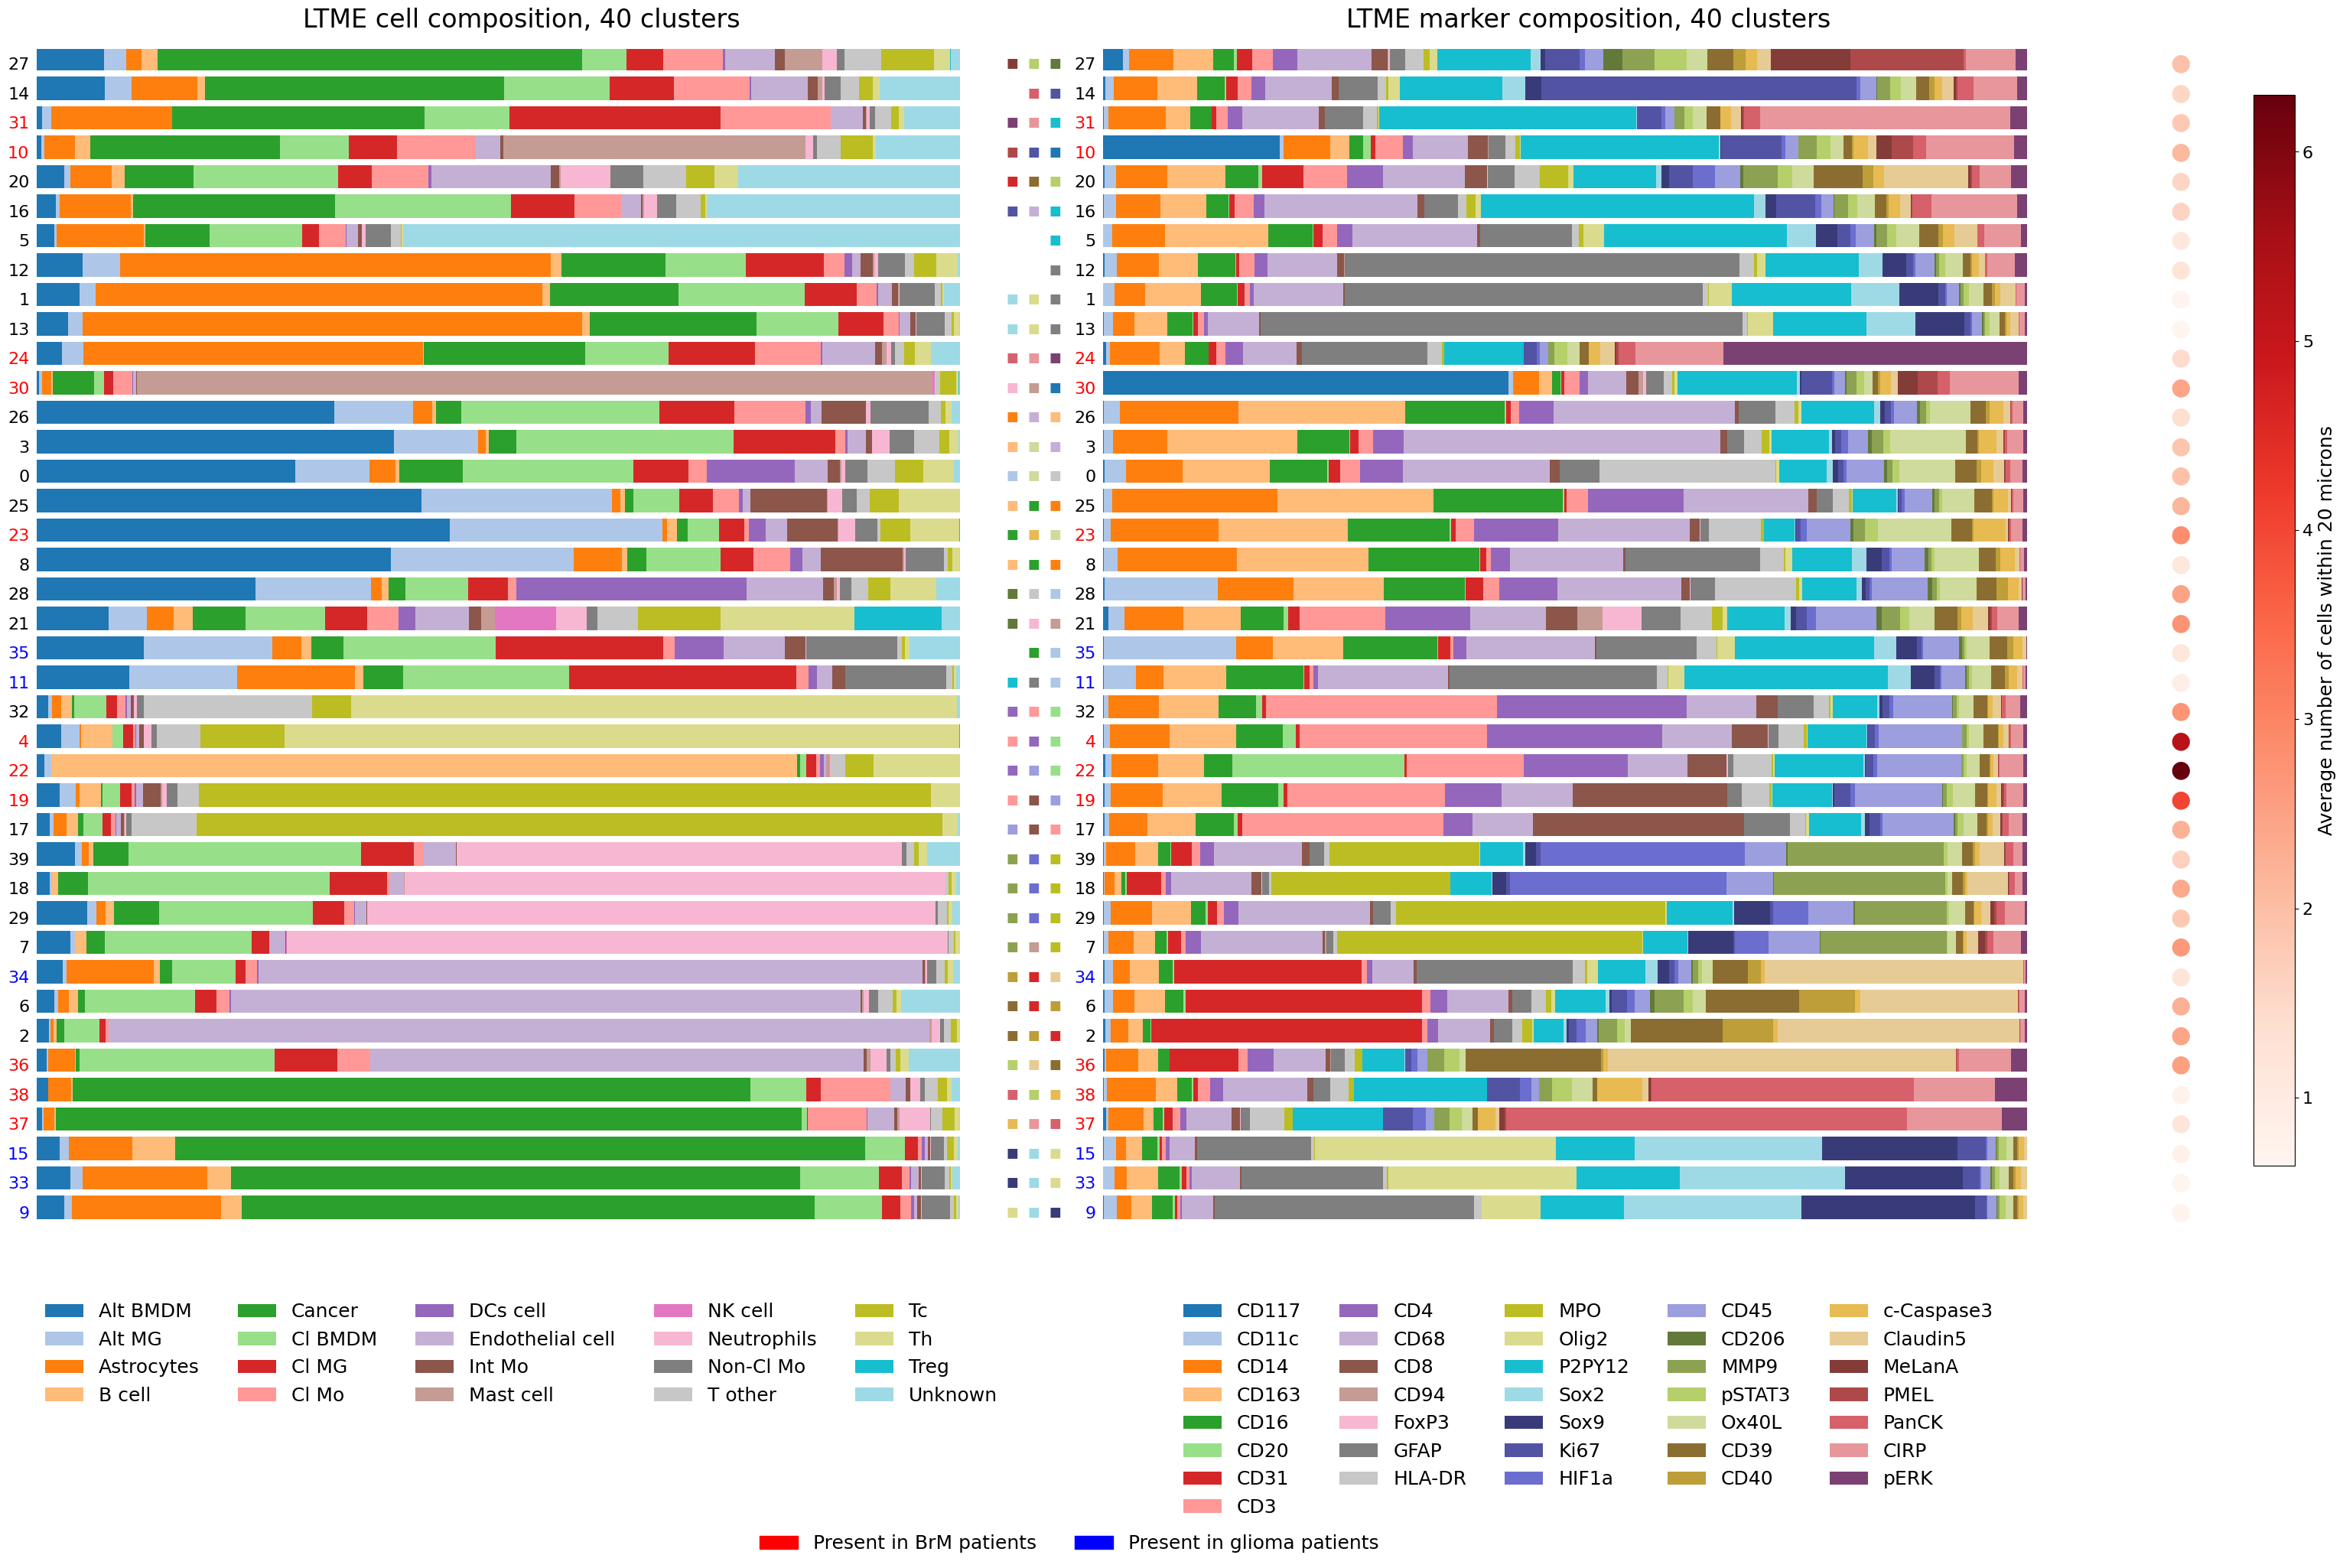

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Ensure the marker DataFrame is in the same order as the composition DataFrame
signature_df = signature_df.reindex(percentages.index)

# Generate the plots side by side using Matplotlib with an extra subplot for the density circles
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 20), gridspec_kw={'width_ratios': [10, 10, 0.01]})  # Give more space to plots 1 and 2

# Plot normalized percentages of cell types
percentages.plot(kind='barh', stacked=True, ax=axes[0], colormap='tab20')
for container in axes[0].containers:
    plt.setp(container, height=0.8)  # Adjust height here for bar thickness

# Adjust title size and space between title and plot
axes[0].set_title(f'LTME cell composition, {n_clusters} clusters', fontsize=24, pad=20)  # Title size and padding
axes[0].set_xlabel('', fontsize=20)
axes[0].set_ylabel('', fontsize=20)
axes[0].tick_params(axis='y', labelsize=18)  # Adjust font size for the y-ticks on the first plot

# Customizing y-axis labels with arrows and label colors based on cluster and c-index
yticklabels = []
for i, module in enumerate(percentages.index):
    dominance_assignment = tile_counts_df.loc[tile_counts_df.index == module, 'Dominance'].values[0]
    label_color = 'black'  # Default color is black
    if dominance_assignment == 'BrM':
        label_color = 'red'
    elif dominance_assignment == 'Glioma':
        label_color = 'blue'

    yticklabels.append(f'{module}')
    axes[0].get_yticklabels()[i].set_color(label_color)

axes[0].set_yticklabels(yticklabels, fontsize=16)


# Plot marker composition (in the same order as the composition plot)
signature_df.plot(kind='barh', stacked=True, ax=axes[1], color=[marker_colors[marker] for marker in signature_df.columns])
for container in axes[1].containers:
    plt.setp(container, height=0.8)
axes[1].set_title(f'LTME marker composition, {n_clusters} clusters', fontsize=24, pad=20)
axes[1].set_xlabel('', fontsize=20)
axes[1].set_ylabel('', fontsize=20)
axes[1].tick_params(axis='y', labelsize=18)

# Customizing y-axis labels with colored squares for markers and label colors
yticklabels = []
for i, module in enumerate(percentages.index):
    dominance_assignment = tile_counts_df.loc[tile_counts_df.index == module, 'Dominance'].values[0]
    label_color = 'black'
    if dominance_assignment == 'BrM':
        label_color = 'red'
    elif dominance_assignment == 'Glioma':
        label_color = 'blue'

    yticklabels.append(f'{module}')
    square_offset = -20
    marker_percentiles = signature_df.rank(pct=True).loc[module]
    top_markers = marker_percentiles[marker_percentiles >= 0.9]
    if len(top_markers) > 3:
        top_markers = top_markers.nlargest(3)

    for marker in top_markers.index:
        marker_color = marker_colors.get(marker, 'black')
        axes[1].annotate('\u25A0', xy=(0, i), xytext=(square_offset - 20, 0),
                         textcoords='offset points', color=marker_color, fontsize=12,
                         ha='right', va='center')
        square_offset -= 20

    axes[1].get_yticklabels()[i].set_color(label_color)

axes[1].set_yticklabels(yticklabels, fontsize=16)

# Removing the box around both plots and the legend
for ax in [axes[0], axes[1]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False)  # Remove axis ticks and small numbers on x-axis

# Existing legend for cell types
axes[0].legend(title='', frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=18)
axes[1].legend(title='', frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=18)

# Custom colored patches for BrM, Glioma, and All patients
red_patch = mpatches.Patch(color='red', label='Present in BrM patients')
blue_patch = mpatches.Patch(color='blue', label='Present in glioma patients')

fig.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False, fontsize=18)

# Dedicated subplot for the density circles
axes[2].set_xlim(0, 1)
axes[2].set_ylim(axes[0].get_ylim())  # Match y-axis limits with the bar plots
axes[2].axis('off')

# Set up the colormap for density values
cmap = cm.get_cmap('Reds')

# Replacing density numbers with circles in the third subplot
for i, module in enumerate(percentages.index):
    nearby_cells_value = average_nearby_df.loc[average_nearby_df['label'] == module, 'average_number_of_nearby_cells'].values[0]
    norm_value = (nearby_cells_value - average_nearby_df['average_number_of_nearby_cells'].min()) / (average_nearby_df['average_number_of_nearby_cells'].max() - average_nearby_df['average_number_of_nearby_cells'].min())
    color = cmap(norm_value)
    axes[2].annotate('●', xy=(0.5, i), va='center', fontsize=22, color=color)

# Removing the x-axis numbers (percentages)
axes[0].xaxis.set_visible(False)
axes[1].xaxis.set_visible(False)

# Adjust only the space between the second and third plots
plt.subplots_adjust(wspace=0.15)

# Vertical color bar (cell density) under the third plot
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])  # Positioning the color bar vertically under the third plot
density_norm = plt.Normalize(vmin=average_nearby_df['average_number_of_nearby_cells'].min(), vmax=average_nearby_df['average_number_of_nearby_cells'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=density_norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Average number of cells within 20 microns', fontsize=18)
cbar.ax.tick_params(labelsize=16)

plt.show()

## Heatmaps

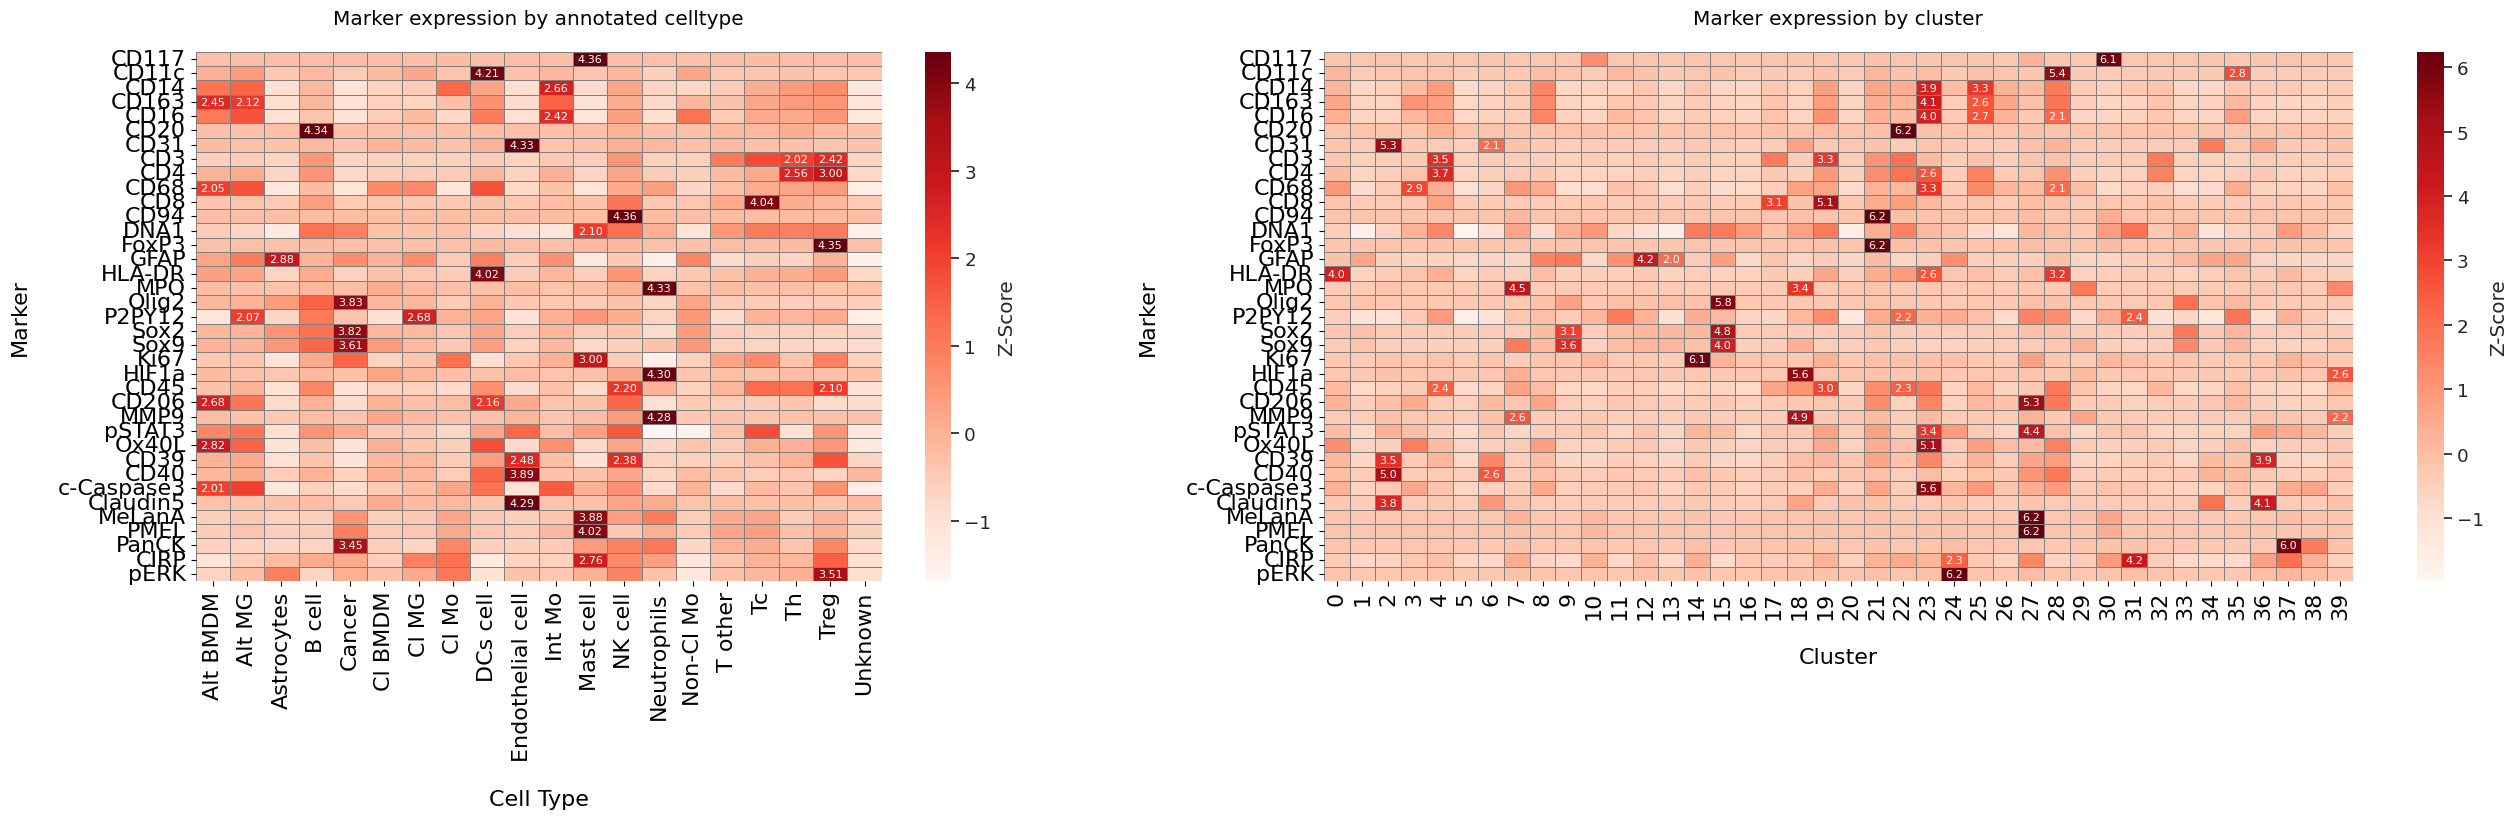

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

# Extract the relevant columns for each grouping separately
marker_df_with_cells = unnormalized_master_df[['celltype'] + marker_names]
marker_df_with_labels = unnormalized_master_df[['labels'] + marker_names]

# Group by CellType and calculate mean marker expression
marker_cells_heatmap = marker_df_with_cells.groupby('celltype').mean(numeric_only=True)

# Apply z-score normalization and round to 2 decimals
marker_cells_heatmap_zscore = marker_cells_heatmap.apply(zscore).round(2)

# Check for any NaN values and replace them with 0
marker_cells_heatmap_zscore = marker_cells_heatmap_zscore.replace([np.inf, -np.inf], np.nan).fillna(0)

# Create a DataFrame for annotations with values only if they are greater than 2, rounded to 2 decimals
annotations = marker_cells_heatmap_zscore.T.applymap(lambda v: f'{v:.2f}' if v > 2 else '')

# Group by Label and calculate mean marker expression
label_cells_heatmap = marker_df_with_labels.groupby('labels').mean(numeric_only=True)

# Apply z-score normalization, round to 2 decimals
label_cells_heatmap_zscore = label_cells_heatmap.apply(zscore).round(2)

# Check for any NaN values and replace them with 0 for label heatmap
label_cells_heatmap_zscore = label_cells_heatmap_zscore.replace([np.inf, -np.inf], np.nan).fillna(0)

# Create a DataFrame for annotations with values only if they are greater than 2, rounded to 2 decimals
annotations_label = label_cells_heatmap_zscore.T.applymap(lambda v: f'{v:.1f}' if v > 2 else '')

# Create subplots for side-by-side heatmaps with adjusted width ratios
fig, axes = plt.subplots(ncols=2, figsize=(28, 10), gridspec_kw={'width_ratios': [1, 1.5]})  # Wider right heatmap

# Plot the first heatmap (Cell Type)
sns.set(font_scale=1.2)
sns.heatmap(
    marker_cells_heatmap_zscore.T,
    cmap='Reds',
    cbar_kws={'label': 'Z-Score'},
    annot=annotations,  # Use custom annotations with values greater than 2
    fmt='',  # No additional formatting needed
    linewidths=0.5,
    linecolor='grey',
    xticklabels=True,
    yticklabels=True,
    annot_kws={"size": 8},
    ax=axes[0]  # Plot on the first axis
)

# Customize title and labels for the first heatmap
axes[0].set_title('Marker expression by annotated celltype', pad=20)
axes[0].set_xlabel('Cell Type', labelpad=20)
axes[0].set_ylabel('Marker', labelpad=20)

# Plot the second heatmap (Label) with increased width
sns.heatmap(
    label_cells_heatmap_zscore.T,
    cmap='Reds',
    cbar_kws={'label': 'Z-Score'},
    annot=annotations_label,  # Use custom annotations with values greater than 2
    fmt='',  # No additional formatting needed
    linewidths=0.5,
    linecolor='grey',
    xticklabels=True,
    yticklabels=True,
    annot_kws={"size": 8},
    ax=axes[1]  # Plot on the second axis
)

# Customize title and labels for the second heatmap
axes[1].set_title('Marker expression by cluster', pad=20)
axes[1].set_xlabel('Cluster', labelpad=20)
axes[1].set_ylabel('Marker', labelpad=20)

plt.tight_layout(pad=5)
plt.show()